# Machine Learning Exercise 6 - Support Vector Machines

This notebook covers a Python-based solution for the sixth programming exercise of the machine learning class on Coursera.  Please refer to the [exercise text](https://github.com/Shubham2320/Andrew-NG-Assignments/blob/master/exercises/ML/ex6.pdf) for detailed descriptions and equations.

NOTE: I skipped exercise 5 in the series because it wasn't that interesting.  If you're following along and wondered why we jumped from 4 to 6, that's why.

In this exercise, we'll be using support vector machines (SVMs) to build a spam classifier.  We'll start with SVMs on some simple 2D data sets to see how they work.  Then we'll do some pre-processing work on a set of raw emails and build a classifier on the processed emails using a SVM to determine if they are spam or not.

The first thing we're going to do is look at a simple 2-dimensional data set and see how a linear SVM works on the data set for varying values of C (similar to the regularization term in linear/logistic regression).  Let's load the data.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
%matplotlib inline
import os
os.chdir('C:\\Users\\hp\\Desktop\\ML-Andrew-NG-Assignement')
raw_data = loadmat('data\ex6data1.mat')
raw_data

{'X': array([[1.9643  , 4.5957  ],
        [2.2753  , 3.8589  ],
        [2.9781  , 4.5651  ],
        [2.932   , 3.5519  ],
        [3.5772  , 2.856   ],
        [4.015   , 3.1937  ],
        [3.3814  , 3.4291  ],
        [3.9113  , 4.1761  ],
        [2.7822  , 4.0431  ],
        [2.5518  , 4.6162  ],
        [3.3698  , 3.9101  ],
        [3.1048  , 3.0709  ],
        [1.9182  , 4.0534  ],
        [2.2638  , 4.3706  ],
        [2.6555  , 3.5008  ],
        [3.1855  , 4.2888  ],
        [3.6579  , 3.8692  ],
        [3.9113  , 3.4291  ],
        [3.6002  , 3.1221  ],
        [3.0357  , 3.3165  ],
        [1.5841  , 3.3575  ],
        [2.0103  , 3.2039  ],
        [1.9527  , 2.7843  ],
        [2.2753  , 2.7127  ],
        [2.3099  , 2.9584  ],
        [2.8283  , 2.6309  ],
        [3.0473  , 2.2931  ],
        [2.4827  , 2.0373  ],
        [2.5057  , 2.3853  ],
        [1.8721  , 2.0577  ],
        [2.0103  , 2.3546  ],
        [1.2269  , 2.3239  ],
        [1.8951  , 2.9174  ],
     

We'll visualize it as a scatter plot where the class label is denoted by a symbol (+ for positive, o for negative).

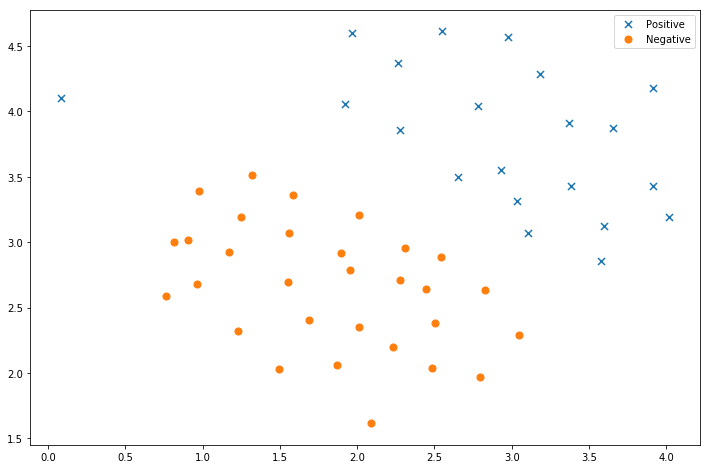

In [7]:
data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])
data['y'] = raw_data['y']

positive = data[data['y'].isin([1])]
negative = data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['X1'], positive['X2'], s=50, marker='x', label='Positive')
ax.scatter(negative['X1'], negative['X2'], s=50, marker='o', label='Negative')
ax.legend()

Notice that there is one outlier positive example that sits apart from the others.  The classes are still linearly separable but it's a very tight fit.  We're going to train a linear support vector machine to learn the class boundary.  In this exercise we're not tasked with implementing an SVM from scratch, so I'm going to use the one built into scikit-learn.

In [8]:
from sklearn import svm
svc = svm.LinearSVC(C=1, loss='hinge', max_iter=1000)
svc

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

For the first experiment we'll use C=1 and see how it performs.

In [9]:
svc.fit(data[['X1', 'X2']], data['y'])
svc.score(data[['X1', 'X2']], data['y'])

0.9803921568627451

It appears that it mis-classified the outlier.  Let's see what happens with a larger value of C.

In [21]:
svc2 = svm.LinearSVC(C=100, loss='hinge', max_iter=1000)
svc2


LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [22]:
svc2.fit(data[['X1', 'X2']], data['y'])
svc2.score(data[['X1', 'X2']], data['y'])

1.0

This time we got a perfect classification of the training data, however by increasing the value of C we've created a decision boundary that is no longer a natural fit for the data.  We can visualize this by looking at the confidence level for each class prediction, which is a function of the point's distance from the hyperplane.

Text(0.5,1,'SVM (C=1) Decision Confidence')

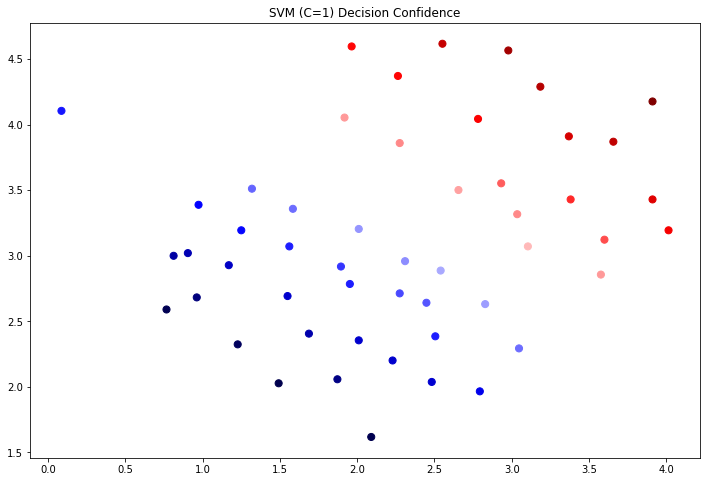

In [23]:
data['SVM 1 Confidence'] = svc.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM 1 Confidence'], cmap='seismic')
ax.set_title('SVM (C=1) Decision Confidence')

Text(0.5,1,'SVM (C=100) Decision Confidence')

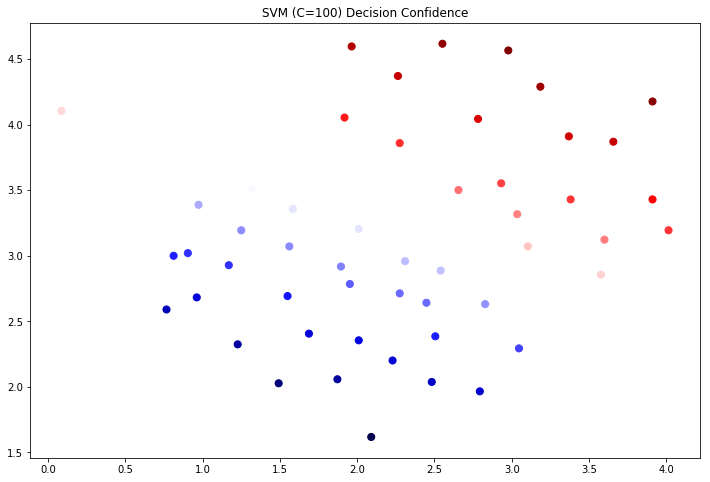

In [24]:
data['SVM 2 Confidence'] = svc2.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM 2 Confidence'], cmap='seismic')
ax.set_title('SVM (C=100) Decision Confidence')

The difference is a bit subtle but look at the color of the points near the boundary.  If you're following along in the exercise text, there's a drawing where the decision boundary is shown as a line on the plot which helps make the difference a bit clearer.

Now we're going to move from a linear SVM to one that's capable of non-linear classification using kernels.  We're first tasked with implementing a gaussian kernel function.  Although scikit-learn has a gaussian kernel built in, for transparency we'll implement one from scratch.

In [25]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-(np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2))))

In [26]:
x1 = np.array([1.0, 2.0, 1.0])
x2 = np.array([0.0, 4.0, -1.0])
sigma = 2

gaussian_kernel(x1, x2, sigma)

0.32465246735834974

That result matches the expected value from the exercise.  Next we're going to examine another data set, this time with a non-linear decision boundary.

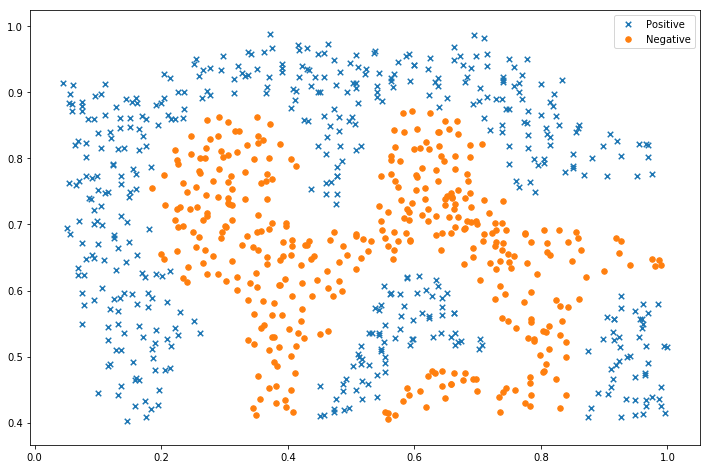

In [28]:
raw_data = loadmat('data/ex6data2.mat')

data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])
data['y'] = raw_data['y']

positive = data[data['y'].isin([1])]
negative = data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['X1'], positive['X2'], s=30, marker='x', label='Positive')
ax.scatter(negative['X1'], negative['X2'], s=30, marker='o', label='Negative')
ax.legend()

For this data set we'll build a support vector machine classifier using the built-in RBF kernel and examine its accuracy on the training data.  To visualize the decision boundary, this time we'll shade the points based on the predicted probability that the instance has a negative class label.  We'll see from the result that it gets most of them right.

In [29]:
svc = svm.SVC(C=100, gamma=10, probability=True)
svc

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
svc.fit(data[['X1', 'X2']], data['y'])
svc.score(data[['X1', 'X2']], data['y'])

0.9698725376593279

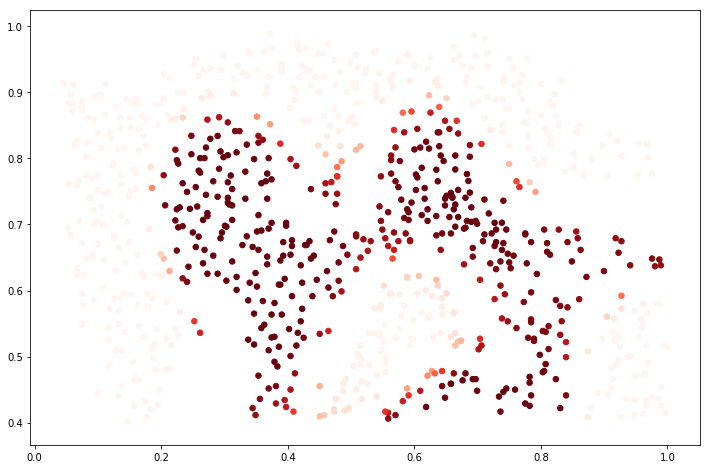

In [32]:
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,0]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=30, c=data['Probability'], cmap='Reds')

For the third data set we're given both training and validation sets and tasked with finding optimal hyper-parameters for an SVM model based on validation set performance.  Although we could use scikit-learn's built-in grid search to do this quite easily, in the spirit of following the exercise directions we'll implement a simple grid search from scratch.

In [34]:
raw_data = loadmat('data/ex6data3.mat')

X = raw_data['X']
Xval = raw_data['Xval']
y = raw_data['y'].ravel()
yval = raw_data['yval'].ravel()

C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
gamma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

best_score = 0
best_params = {'C': None, 'gamma': None}

for C in C_values:
    for gamma in gamma_values:
        svc = svm.SVC(C=C, gamma=gamma)
        svc.fit(X, y)
        score = svc.score(Xval, yval)
        
        if score > best_score:
            best_score = score
            best_params['C'] = C
            best_params['gamma'] = gamma

best_score, best_params

(0.965, {'C': 0.3, 'gamma': 100})

Now we'll move on to the second part of the exercise.  In this part our objective is to use SVMs to build a spam filter.  In the exercise text, there's a task involving some text pre-processing to get our data in a format suitable for an SVM to handle.  However, the task is pretty trivial (mapping words to an ID from a dictionary that's provided for the exercise) and the rest of the pre-processing steps such as HTML removal, stemming, normalization etc. are already done.  Rather than reproduce these pre-processing steps, I'm going to skip ahead to the machine learning task which involves building a classifier from pre-processed train and test data sets consisting of spam and non-spam emails transformed to word occurance vectors.

In [35]:
spam_train = loadmat('data/spamTrain.mat')
spam_test = loadmat('data/spamTest.mat')

spam_train

{'X': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:27:25 2011',
 '__version__': '1.0',
 'y': array([[1],
        [1],
        [0],
        ...,
        [1],
        [0],
        [0]], dtype=uint8)}

In [36]:
X = spam_train['X']
Xtest = spam_test['Xtest']
y = spam_train['y'].ravel()
ytest = spam_test['ytest'].ravel()

X.shape, y.shape, Xtest.shape, ytest.shape

((4000, 1899), (4000,), (1000, 1899), (1000,))

Each document has been converted to a vector with 1,899 dimensions corresponding to the 1,899 words in the vocabulary.  The values are binary, indicating the presence or absence of the word in the document.  At this point, training and evaluation are just a matter of fitting the testing the classifer. 

In [17]:
svc = svm.SVC()
svc.fit(X, y)
print('Training accuracy = {0}%'.format(np.round(svc.score(X, y) * 100, 2)))

Training accuracy = 94.4%


In [18]:
print('Test accuracy = {0}%'.format(np.round(svc.score(Xtest, ytest) * 100, 2)))

Test accuracy = 95.3%


This result is with the default parameters.  We could probably get it a bit higher using some parameter tuning, but 95% accuracy still isn't bad.

That concludes exercise 6!  In the next exercise we'll perform clustering and image compression with K-Means and principal component analysis.